In [1]:
#import the required packages
import cv2
import tensorflow as tf
from tensorflow.keras import layers
from IPython import display
import matplotlib.pyplot as plt
import numpy as np
import tensorflow_datasets as tfds
%matplotlib inline

import cv2
import os
import numpy as np

In [2]:


def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder,filename))
        if img is not None:
            gray_image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            images.append(gray_image)
    return images

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
imgs0=load_images_from_folder("/content/drive/MyDrive/preprocessed_training/abnormal/0")
imgs1=load_images_from_folder("/content/drive/MyDrive/preprocessed_training/abnormal/1")


labels=[]
X=imgs0+imgs1
label0=[0]*len(imgs0)
label1=[1]*len(imgs1)

y=label0+label1

X=np.asarray(X)
y=np.asarray(y)

In [5]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


trainX, testX, trainy, testy = train_test_split(X, y, test_size=0.1, random_state=42)

In [6]:
def define_discriminator(in_shape=(512,512,1), n_classes=2):
	# label input
	input_label = Input(shape=(1,))
	# embedding for categorical input
	li = Embedding(n_classes, 50)(input_label)
	# scale up to image dimensions with linear activation
	number_nodes = in_shape[0] * in_shape[1]
	li = Dense(number_nodes)(li)
	# reshape to additional channel
	li = Reshape((in_shape[0], in_shape[1], 1))(li)
	# image input
	in_image = Input(shape=in_shape)
	# concatenate label as a channel
	merge = Concatenate()([in_image, li])
	# downsampling
	fe = Conv2D(128, (3,3), strides=(2,2), padding='same')(merge)
	fe = LeakyReLU(alpha=0.2)(fe)
	# downsampling
	fe = Conv2D(128, (3,3), strides=(2,2), padding='same')(fe)
	fe = LeakyReLU(alpha=0.2)(fe)
  
 	# downsampling
	fe = Conv2D(128, (3,3), strides=(2,2), padding='same')(fe)
	fe = LeakyReLU(alpha=0.2)(fe)
 
 	# downsampling
	fe = Conv2D(128, (3,3), strides=(2,2), padding='same')(fe)
	fe = LeakyReLU(alpha=0.2)(fe)
 

 	# downsampling
	fe = Conv2D(128, (3,3), strides=(2,2), padding='same')(fe)
	fe = LeakyReLU(alpha=0.2)(fe)
 

 	# downsampling
	fe = Conv2D(128, (3,3), strides=(2,2), padding='same')(fe)
	fe = LeakyReLU(alpha=0.2)(fe)
 
	# flatten feature maps
	fe = Flatten()(fe)
	# dropout
	fe = Dropout(0.4)(fe)
	# output
	out_layer = Dense(1, activation='sigmoid')(fe)
	# define model
	model = Model([in_image, in_label], out_layer)
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
	return model

In [7]:
def define_generator(latent_dim, n_classes=2):
	# label input
	in_label = Input(shape=(1,))
	# embedding for categorical input
	li = Embedding(n_classes, 50)(in_label)
	# linear multiplication
	n_nodes = 8 * 8
	li = Dense(n_nodes)(li)
	# reshape to additional channel
	li = Reshape((8, 8, 1))(li)
	# image generator input
	in_lat = Input(shape=(latent_dim,))
	# foundation for 7x7 image
	n_nodes = 128 * 8 * 8
	gen = Dense(n_nodes)(in_lat)
	gen = LeakyReLU(alpha=0.2)(gen)
	gen = Reshape((8, 8, 128))(gen)
	# merge the image generator and input label
	merge = Concatenate()([gen, li])
	# upsample to 14x14
	gen = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(merge)
	gen = LeakyReLU(alpha=0.2)(gen)
	# upsample to 28x28
	gen = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(gen)
	gen = LeakyReLU(alpha=0.2)(gen)

	# upsample to 28x28
	gen = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(gen)
	gen = LeakyReLU(alpha=0.2)(gen)
 
 	# upsample to 28x28
	gen = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(gen)
	gen = LeakyReLU(alpha=0.2)(gen)
 
 	# upsample to 28x28
	gen = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(gen)
	gen = LeakyReLU(alpha=0.2)(gen)
 
 	# upsample to 28x28
	gen = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(gen)
	gen = LeakyReLU(alpha=0.2)(gen)
 


	# output
	out_layer = Conv2D(1, (7,7), activation='tanh', padding='same')(gen)
	# define model
	model = Model([in_lat, in_label], out_layer)
	return model

In [8]:
def define_gan(g_model, d_model):
	# make weights in the discriminator untrainable
	d_model.trainable = False
	# get noise and input labels from generator model
	gen_noise, gen_label = g_model.input
	# get image output from the generator model
	gen_output = g_model.output
	# connect image output and label input from generator as inputs to discriminator
	gan_output = d_model([gen_output, gen_label])
	# define gan model as taking noise and label and outputting a classification
	model = Model([gen_noise, gen_label], gan_output)
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt)
	return model

In [9]:
def load_real_samples():
	# load dataset
	#(trainX, trainy), (_, _) = load_data()
	# expand to 3d, e.g. add channels
	X = expand_dims(trainX, axis=-1)
	# convert from ints to floats
	X = X.astype('float32')
	# scale from [0,255] to [-1,1]
	X = (X - 127.5) / 127.5
	return [X, trainy]
 
# select real samples
def generate_real_samples(dataset, n_samples):
	# split into images and labels
	images, labels = dataset
	# choose random instances
	ix = randint(0, images.shape[0], n_samples)
	# select images and labels
	X, labels = images[ix], labels[ix]
	# generate class labels
	y = ones((n_samples, 1))
	return [X, labels], y

In [10]:
def generate_latent_points(latent_dim, n_samples, n_classes=2):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	z_input = x_input.reshape(n_samples, latent_dim)
	# generate labels
	labels = randint(0, n_classes, n_samples)
	return [z_input, labels]
 
# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n_samples):
	# generate points in latent space
	z_input, labels_input = generate_latent_points(latent_dim, n_samples)
	# predict outputs
	images = generator.predict([z_input, labels_input])
	# create class labels
	y = zeros((n_samples, 1))
	return [images, labels_input], y

In [11]:

def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=5, n_batch=10):
	dd=[]
	gg=[]
	bat_per_epo = int(dataset[0].shape[0] / n_batch)
	half_batch = int(n_batch / 2)
	# manually enumerate the epochs
	for i in range(n_epochs):
		
		# enumerate in batches over the training set
		for j in range(bat_per_epo):

			# get randomly selected 'real' samples
			[X_real, labels_real], y_real = generate_real_samples(dataset, half_batch)
			# update discriminator model weights
			d_loss1, _ = d_model.train_on_batch([X_real, labels_real], y_real)
			# generate 'fake' examples
			[X_fake, labels], y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
			# update discriminator model weights
			d_loss2, _ = d_model.train_on_batch([X_fake, labels], y_fake)
			# prepare points in latent space as input for the generator
			[z_input, labels_input] = generate_latent_points(latent_dim, n_batch)
			# create inverted labels for the fake samples
			y_gan = ones((n_batch, 1))
			# update the generator via the discriminator's error
			g_loss = gan_model.train_on_batch([z_input, labels_input], y_gan)
	 		
			# summarise the loss on this batch
			print('>%d, %d/%d, d1=%.3f, d2=%.3f g=%.3f' %
				(i+1, j+1, bat_per_epo, d_loss1, d_loss2, g_loss))
		gg.append(g_loss)
		dd.append(((d_loss1+d_loss2)/2))

	# save the generator model
	g_model.save('cgan_generator.h5')
	return gg,dd



In [12]:
latent_dim = 100
n_epochs=200 
n_batch=16

In [13]:
from numpy import expand_dims
from numpy import zeros
from numpy import ones
from numpy.random import randn
from numpy.random import randint
from keras.datasets.fashion_mnist import load_data
from tensorflow.keras.optimizers import Adam
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Dropout
from keras.layers import Embedding
from keras.layers import Concatenate
# create the discriminator
d_model = define_discriminator()
# create the generator
g_model = define_generator(latent_dim)
# create the gan
gan_model = define_gan(g_model, d_model)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [14]:
dataset = load_real_samples()


#Training

In [15]:

dd,gg=train(g_model, d_model, gan_model, dataset, latent_dim,n_epochs,n_batch)

>1, 1/24, d1=0.676, d2=0.696 g=0.692
>1, 2/24, d1=0.606, d2=0.695 g=0.692
>1, 3/24, d1=0.452, d2=0.697 g=0.693
>1, 4/24, d1=0.228, d2=0.698 g=0.694
>1, 5/24, d1=0.045, d2=0.694 g=0.697
>1, 6/24, d1=0.003, d2=0.690 g=0.701
>1, 7/24, d1=0.002, d2=0.698 g=0.706
>1, 8/24, d1=0.002, d2=0.686 g=0.710
>1, 9/24, d1=0.002, d2=0.708 g=0.716
>1, 10/24, d1=0.007, d2=0.716 g=0.725
>1, 11/24, d1=0.035, d2=0.766 g=0.745
>1, 12/24, d1=0.158, d2=0.953 g=0.735
>1, 13/24, d1=0.168, d2=1.183 g=0.768
>1, 14/24, d1=0.596, d2=0.727 g=0.737
>1, 15/24, d1=0.588, d2=0.791 g=0.752
>1, 16/24, d1=0.551, d2=0.662 g=0.858
>1, 17/24, d1=0.507, d2=0.609 g=1.119
>1, 18/24, d1=0.482, d2=0.457 g=1.751
>1, 19/24, d1=0.359, d2=0.211 g=2.672
>1, 20/24, d1=0.143, d2=0.218 g=2.292
>1, 21/24, d1=0.046, d2=0.402 g=1.451
>1, 22/24, d1=0.038, d2=0.620 g=0.926
>1, 23/24, d1=0.014, d2=0.643 g=0.797
>1, 24/24, d1=0.004, d2=0.628 g=0.809
>2, 1/24, d1=0.001, d2=0.594 g=0.855
>2, 2/24, d1=0.003, d2=0.559 g=0.905
>2, 3/24, d1=0.002, d2=

>200, 24/24, d1=0.074, d2=0.032 g=3.811


In [16]:
print(gg)
print(dd)




[0.3157422348158434, 0.0010121552040800452, 0.007588646141812205, 0.006509070182801224, 0.0006669452704954892, 0.007859823061153293, 0.007969002239406109, 0.005913235363550484, 0.008476080562104471, 0.014546471880748868, 0.10242985974036856, 0.5409258638155734, 0.007661080453544855, 0.06203463673591614, 0.01847884152084589, 0.8669612407684326, 0.05479812063276768, 0.07320873253047466, 0.04158818475843873, 0.07546286564320326, 0.1022964222356677, 0.042253658175468445, 0.1160334162414074, 0.1381414793431759, 0.06141262501478195, 0.11811069026589394, 0.0532638281583786, 0.061481441371142864, 0.46081286668777466, 0.13089453428983688, 0.4848621168639511, 0.22224346548318863, 0.013553892727941275, 0.05156112741678953, 0.017718205228447914, 0.19499162584543228, 0.007967508799993084, 0.23802997544407845, 0.07705960236489773, 0.10053926520049572, 0.04628457687795162, 1.3796378374099731, 0.17716846615076065, 0.16982246935367584, 0.20210987329483032, 0.06695674732327461, 0.06757542490959167, 0.16

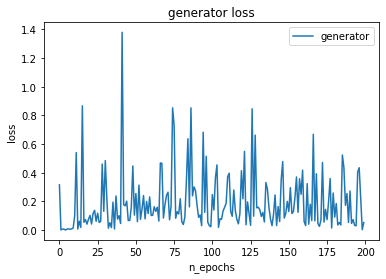

In [17]:
import matplotlib.pyplot as plt
plt.plot(gg)

plt.xlabel('n_epochs')
plt.ylabel('loss')
plt.legend(['generator'])
plt.title('generator loss')
 
plt.show()

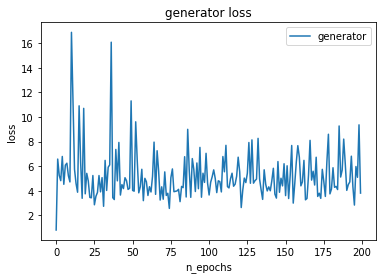

In [18]:
import matplotlib.pyplot as plt
plt.plot(dd)

plt.xlabel('n_epochs')
plt.ylabel('loss')
plt.legend(['generator'])
plt.title('generator loss')
 
plt.show()

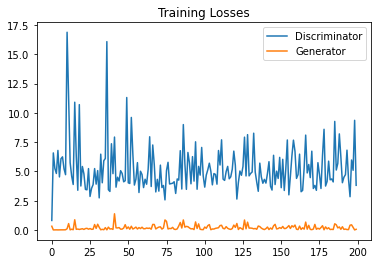

In [27]:
fig, ax = plt.subplots()
plt.plot(dd, label='Discriminator')
plt.plot(gg, label='Generator')
plt.title("Training Losses")
plt.legend()

In [19]:
from numpy import asarray
from numpy.random import randn
from numpy.random import randint
from keras.models import load_model
from matplotlib import pyplot
 
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples, n_classes=4):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	z_input = x_input.reshape(n_samples, latent_dim)
	# generate labels
	labels = randint(0, n_classes, n_samples)
	return [z_input, labels]
 
# create and save a plot of generated images
def save_plot(examples, n):
	# plot images
	for i in range(n * n):
		# define subplot
		pyplot.subplot(n, n, 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(examples[i, :, :, 0], cmap='gray_r')
	pyplot.show()
 

# Load model and check plots

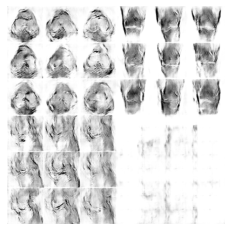

In [22]:
model = load_model('cgan_generator.h5')
# generate images
latent_points, tc = generate_latent_points(100, 1)
# specify labels
#labels = asarray([x for _ in range(1) for x in range(1)])
# generate images
labels=np.asarray([2])
X  = model.predict([latent_points, labels])
# scale from [-1,1] to [0,1]
X = (X + 1) / 2.0
# plot the result
save_plot(X, 1)

#Generate Image

In [33]:
def predict(labels):
  latent_points, tc = generate_latent_points(100, 1)
  X  = model.predict([latent_points, np.asarray([labels])])
  #X = (X + 1) / 2.0
  new_img = X[0].reshape(X[0].shape[0], (X[0].shape[1]*X[0].shape[2]))
  dc=new_img* 127.5 + 127.5

  cv2.imwrite("{}.png".format(labels),dc)


In [34]:

predict(300)
  